In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from scipy.stats import norm

class OptionHedgingEnv(gym.Env):
    metadata = {"render_modes": []}  # Optional, no rendering used here

    def __init__(self, days=30, S0=50, K=50, sigma=0.2, r=0.01, short_calls=10, hedge_cost_coeff=0.01, hedge_penalty_weight=10, curriculum=False):
        super().__init__()
        self.days = days
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.r = r
        self.short_calls = short_calls
        self.dt = 1 / 365
        self.hedge_cost_coeff = hedge_cost_coeff
        self.hedge_penalty_weight = hedge_penalty_weight
        self.curriculum = curriculum

        # Action: continuous hedge ratio between -1 and 1
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation: normalized [S, T, delta, gamma, vega, sigma]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.day = 0
        self.S = self.S0
        self.hedge_position = 0
        self.prev_hedge = 0
        self.total_pnl = 0

        self.daily_returns = np.random.normal(loc=0, scale=self.sigma * np.sqrt(self.dt), size=self.days)
        self.state = self._get_state()
        return self.state, {}

    def step(self, action):
        hedge_ratio = float(np.clip(action[0], -1, 1))
        self.prev_hedge = self.hedge_position
        self.hedge_position = hedge_ratio * self.short_calls

        dS = self.S * (np.exp(self.daily_returns[self.day]) - 1)
        self.S += dS
        self.day += 1
        T = (self.days - self.day) / 365

        # Greeks
        delta = -self.short_calls * self._call_delta(self.S, self.K, T, self.r, self.sigma)
        d_portfolio = delta * dS
        d_hedge = self.hedge_position * dS
        hedge_cost = self.hedge_cost_coeff * abs(self.hedge_position - self.prev_hedge)

        # Hedge penalty
        hedge_error_penalty = self.hedge_penalty_weight * (self.hedge_position - delta) ** 2

        pnl = d_portfolio + d_hedge
        reward = - (pnl ** 2) - hedge_cost - hedge_error_penalty

        self.total_pnl += pnl
        done = self.day >= self.days
        self.state = self._get_state()
        return self.state, reward, done, False, {}

    def _get_state(self):
        T = (self.days - self.day) / 365
        delta = -self.short_calls * self._call_delta(self.S, self.K, T, self.r, self.sigma)
        gamma = -self.short_calls * self._call_gamma(self.S, self.K, T, self.r, self.sigma)
        vega = -self.short_calls * self._call_vega(self.S, self.K, T, self.r, self.sigma)
        
        # Normalize each feature
        S_norm = (self.S - self.S0) / self.S0
        T_norm = T * 365 / self.days
        delta_norm = delta / self.short_calls
        gamma_norm = gamma / self.short_calls
        vega_norm = vega / self.short_calls / 100
        sigma_norm = self.sigma  # Already in [0, 1] range typically

        return np.array([S_norm, T_norm, delta_norm, gamma_norm, vega_norm, sigma_norm], dtype=np.float32)


    def _call_delta(self, S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return norm.cdf(d1)

    def _call_gamma(self, S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return norm.pdf(d1) / (S * sigma * np.sqrt(T))

    def _call_vega(self, S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * norm.pdf(d1) * np.sqrt(T) / 100

In [22]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

env = OptionHedgingEnv()
check_env(env)

# Train PPO agent
model = PPO("MlpPolicy", env, learning_rate=5e-5, n_steps=2048, batch_size=64,
    ent_coef=0.01, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
    vf_coef=0.5, max_grad_norm=0.5, verbose=1)

model.learn(total_timesteps=300_000)

# Save model
model.save("ppo_hedging_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:92: RuntimeWarning: invalid value encountered in scalar divide
  return norm.pdf(d1) / (S * sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 30        |
|    ep_rew_mean     | -2.75e+04 |
| time/              |           |
|    fps             | 2252      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | -2.92e+04    |
| time/                   |              |
|    fps                  | 1824         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 6.561552e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 9.95e-06     |
|    

C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:92: RuntimeWarning: invalid value encountered in scalar divide
  return norm.pdf(d1) / (S * sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


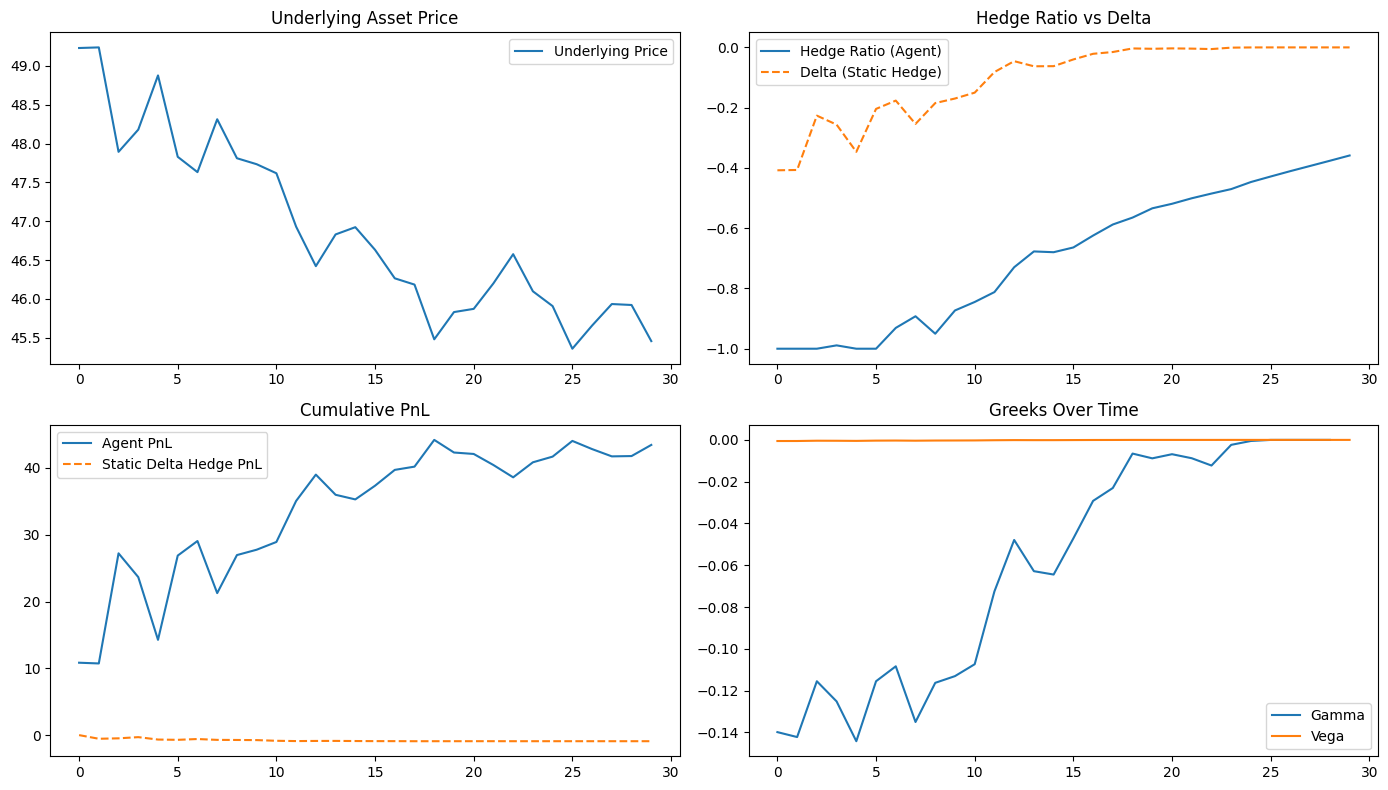

In [23]:
# Load trained model
from matplotlib import pyplot as plt


model = PPO.load("ppo_hedging_agent")

# Create test environment
env = OptionHedgingEnv()
obs, _ = env.reset()

# Data storage
prices, hedge_actions, pnls = [], [], []
deltas, gammas, vegas = [], [], []

done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    prices.append(env.S)
    hedge_actions.append(action[0])
    pnls.append(env.total_pnl)
    deltas.append(obs[2])  # assuming obs = [S, t, delta, gamma, vega]
    gammas.append(obs[3])
    vegas.append(obs[4])

# Baseline: constant delta hedge
baseline_pnl = np.cumsum([
    -delta * (prices[i+1] - prices[i]) if i < len(prices)-1 else 0
    for i, delta in enumerate(deltas)
])

# Plot
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(prices, label='Underlying Price')
plt.title("Underlying Asset Price")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(hedge_actions, label='Hedge Ratio (Agent)')
plt.plot(deltas, label='Delta (Static Hedge)', linestyle='--')
plt.title("Hedge Ratio vs Delta")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pnls, label='Agent PnL')
plt.plot(baseline_pnl, label='Static Delta Hedge PnL', linestyle='--')
plt.title("Cumulative PnL")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gammas, label='Gamma')
plt.plot(vegas, label='Vega')
plt.title("Greeks Over Time")
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:92: RuntimeWarning: invalid value encountered in scalar divide
  return norm.pdf(d1) / (S * sigma * np.sqrt(T))
C:\Users\Manas\AppData\Local\Temp\ipykernel_34716\3458053397.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


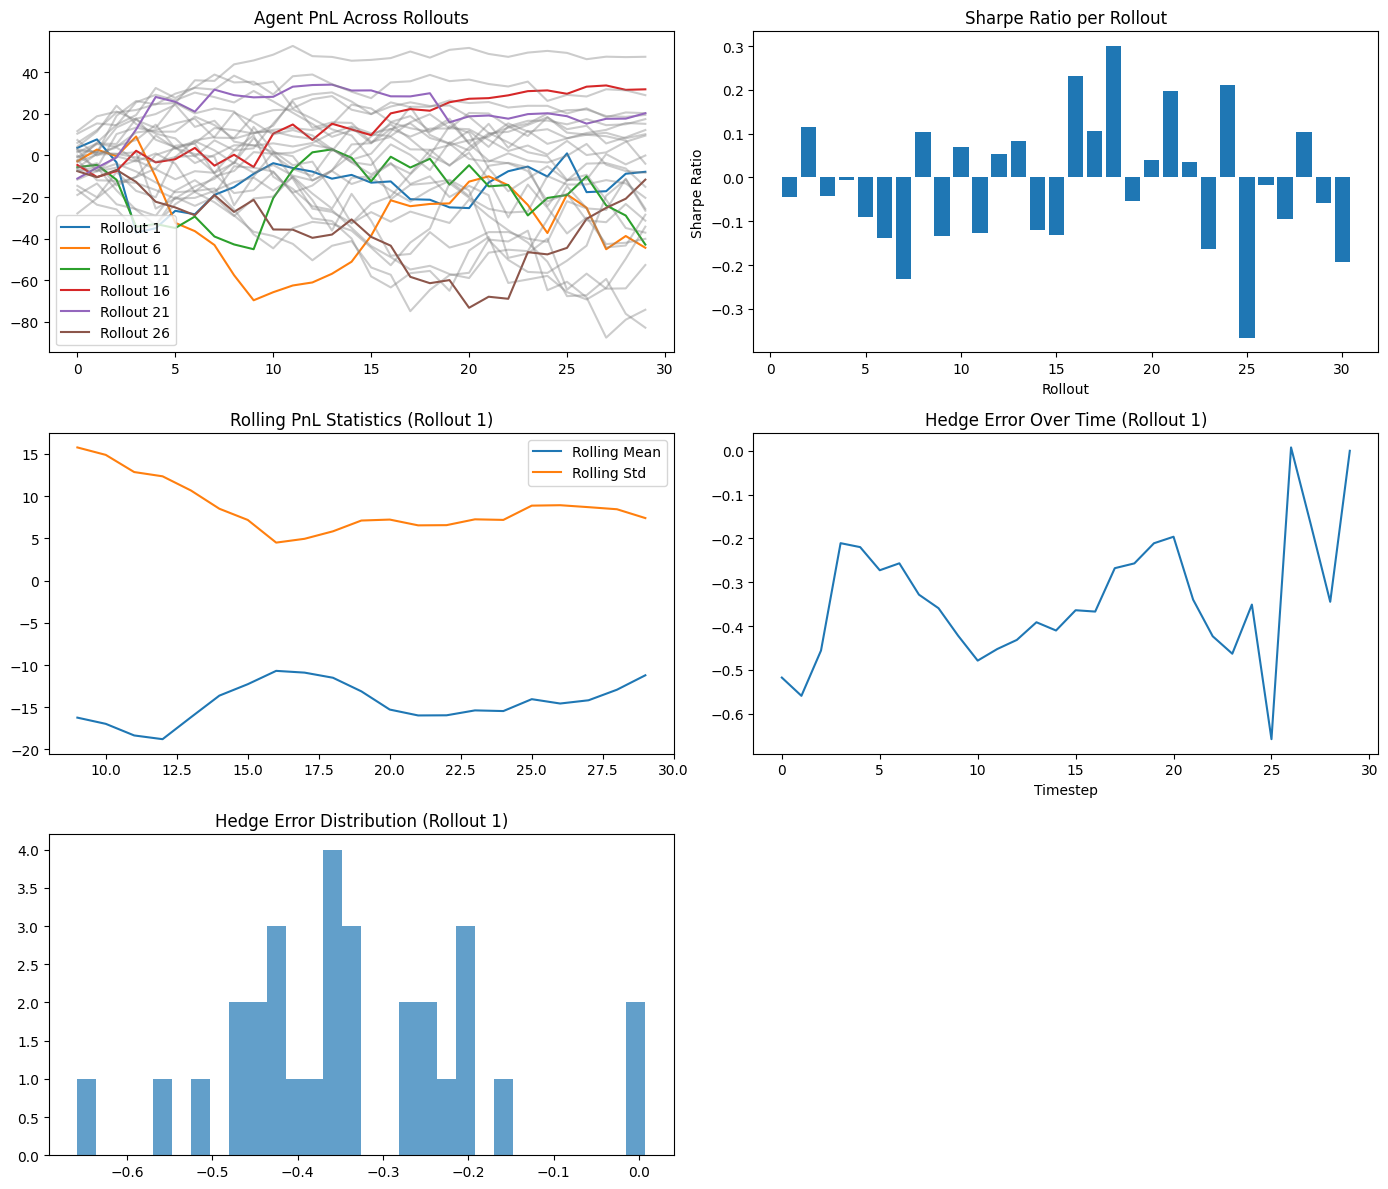

,Rollout,Sharpe Ratio,Final PnL
0,1,-0.043621,-7.887864
1,2,0.114052,10.171462
2,3,-0.041304,-8.346852
3,4,-0.006607,9.500345
4,5,-0.089742,-25.677185
5,6,-0.137534,-44.409655
6,7,-0.231632,-74.187208
7,8,0.104060,20.291426
8,9,-0.133955,-37.133071
9,10,0.069363,12.184115


In [28]:
import pandas as pd

model = PPO.load("ppo_hedging_agent")

# Parameters
n_rollouts = 30
rolling_window = 10

# Data containers
all_pnls = []
all_hedge_errors = []
all_sharpes = []

# Run test rollouts
for _ in range(n_rollouts):
    env = OptionHedgingEnv()
    obs, _ = env.reset() if isinstance(env.reset(), tuple) else (env.reset(), None)
    
    done = False
    pnl = []
    hedge_errors = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        pnl.append(env.total_pnl)  # make sure your env tracks total_pnl
        hedge_errors.append(action[0] - obs[2])  # obs[2] = delta

    pnl = np.array(pnl)
    all_pnls.append(pnl)
    all_hedge_errors.append(np.array(hedge_errors))
    if len(pnl) > 1:
        returns = np.diff(pnl)
        sharpe = np.mean(returns) / (np.std(returns) + 1e-8)
    else:
        sharpe = 0.0
    all_sharpes.append(sharpe)

# Plot results
plt.figure(figsize=(14, 12))

# Plot cumulative PnL
plt.subplot(3, 2, 1)
for i, pnl in enumerate(all_pnls):
    if i % 5 == 0:
        plt.plot(pnl, label=f'Rollout {i+1}')
    else:
        plt.plot(pnl, color='gray', alpha=0.4)
plt.title("Agent PnL Across Rollouts")
plt.legend()

# Plot Sharpe ratios
plt.subplot(3, 2, 2)
plt.bar(range(1, n_rollouts+1), all_sharpes)
plt.title("Sharpe Ratio per Rollout")
plt.xlabel("Rollout")
plt.ylabel("Sharpe Ratio")

# Rolling PnL stats (first rollout)
pnl_series = pd.Series(all_pnls[0])
rolling_mean = pnl_series.rolling(window=rolling_window).mean()
rolling_std = pnl_series.rolling(window=rolling_window).std()

plt.subplot(3, 2, 3)
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.title(f"Rolling PnL Statistics (Rollout 1)")
plt.legend()

# Hedge Error Plot (first rollout)
plt.subplot(3, 2, 4)
plt.plot(all_hedge_errors[0])
plt.title("Hedge Error Over Time (Rollout 1)")
plt.xlabel("Timestep")

# Histogram of hedge error (first rollout)
plt.subplot(3, 2, 5)
plt.hist(all_hedge_errors[0], bins=30, alpha=0.7)
plt.title("Hedge Error Distribution (Rollout 1)")

plt.tight_layout()
plt.show()

# Display Sharpe summary
summary_df = pd.DataFrame({
    "Rollout": list(range(1, n_rollouts + 1)),
    "Sharpe Ratio": all_sharpes,
    "Final PnL": [pnl[-1] for pnl in all_pnls]
})
display(summary_df)